<a href="https://colab.research.google.com/github/mmooppss/TensorFlow-pruebas/blob/main/Brain_Tumor_detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importamos Keras desde Tensorflow y comprobamos que se esta corriendo con la GPU

In [ ]:
from tensorflow import keras
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

# Descargamos el dataset desde Kaggle

In [ ]:
!kaggle datasets download -d preetviradiya/brian-tumor-dataset -p /content

!unzip -q /content/brian-tumor-dataset.zip -d /content/Brain_tumor

!rm /content/brian-tumor-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 99% 106M/107M [00:05<00:00, 23.6MB/s]
100% 107M/107M [00:06<00:00, 18.6MB/s]


In [ ]:
dataset_path = '/content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set'

!ls "$dataset_path"

'Brain Tumor'   Healthy


# Definimos la función para filtrar las imagenes que esten dañadas o que no esten en el formato jpg o jpeg

In [ ]:
from PIL import Image
import os

def clean_dataset(dataset_path):
    deleted_imgs = 0
    folder_names = os.listdir(dataset_path)

    for folder_name in folder_names:
        folder_path = os.path.join(dataset_path, folder_name)
        if os.path.isdir(folder_path):
            for image in os.listdir(folder_path):
                img_path = os.path.join(folder_path, image)

                # Verifica que la extensión sea .jpg o .jpeg
                if not image.lower().endswith(('.jpg', '.jpeg')):
                    # Si no es .jpg o .jpeg, eliminamos el archivo (cualquier otro formato no deseado)
                    os.remove(img_path)
                    deleted_imgs += 1
                    print(f"Imagen eliminada: {img_path}")
                    continue  # Pasar al siguiente archivo

                try:
                    # Verifica si la imagen puede ser cargada (formato válido)
                    with Image.open(img_path) as img:
                        img.load()  # Cargar toda la imagen para verificar
                except (IOError, SyntaxError) as e:
                    # Si la imagen tiene un error, eliminarla
                    os.remove(img_path)
                    deleted_imgs += 1
                    print(f"Imagen eliminada (error en la carga): {img_path} - Error: {e}")

    print(f"Total de imágenes eliminadas: {deleted_imgs}")

# Llama a la función para limpiar el dataset
dataset_path = '/content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set'
clean_dataset(dataset_path)


Procesando archivo: /content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (1556).jpg
Procesando archivo: /content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (387).jpg
Procesando archivo: /content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (653).jpg
Procesando archivo: /content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (1366).jpg
Procesando archivo: /content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (1454).jpg
Procesando archivo: /content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (997).jpg
Procesando archivo: /content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (1724).jpg
Procesando archivo: /content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (562).jpg
Procesando archivo: /content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/N

# Comprobamos si las imagenes estan en RGB o en escala de grises

In [ ]:
from PIL import Image

# Cargar una imagen
img_path = "/content/Brain_tumor/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg"

with Image.open(img_path) as img:
    # Comprobar el modo de la imagen
    print(f"Modo de la imagen: {img.mode}")

    # Determinar si es RGB o escala de grises
    if img.mode == "RGB":
        print("La imagen es RGB (color).")
    elif img.mode == "L":
        print("La imagen esta en escala de grises.")
    else:
        print(f"La imagen tiene un modo desconocido: {img.mode}")


Modo de la imagen: RGB
La imagen es RGB (color).


# Comprobamos si las imagenes son de distinto tamaño

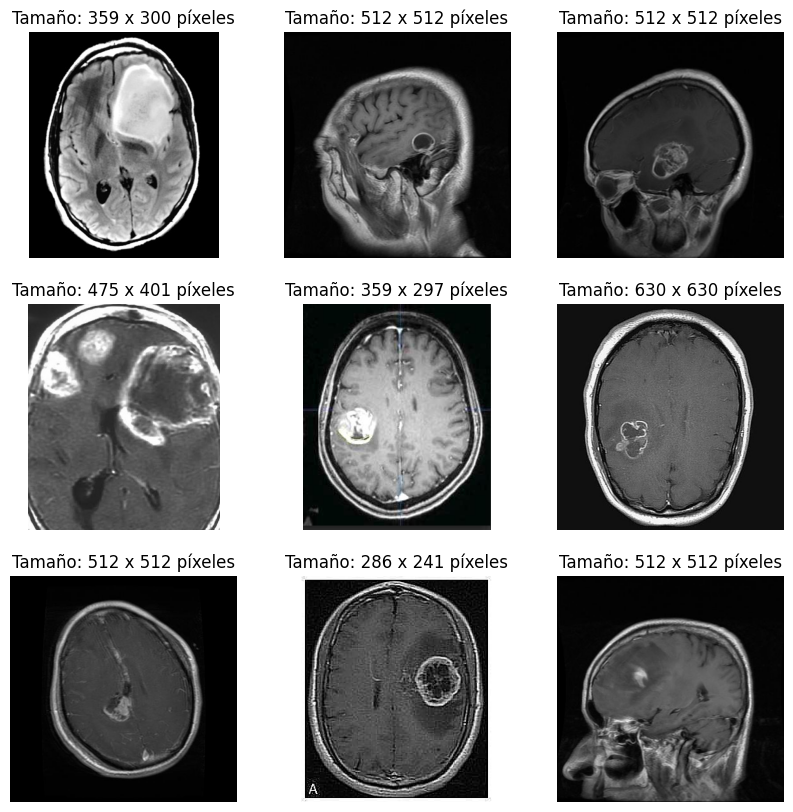

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

plt.figure(figsize=(10, 10))

folder_path = os.path.join(dataset_path, "Brain Tumor")
for i, image in enumerate(os.listdir(folder_path)[:9]):
  img_path = os.path.join(folder_path, image)
  img = mpimg.imread(img_path)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} píxeles")
  plt.axis("off")

plt.show()

# Buscamos la dimensión media de las imagenes

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def find_average_image_size(dataset_path):
    total_width = 0
    total_height = 0
    total_images = 0

    folder_names = os.listdir(dataset_path)

    # Recorrer todas las imágenes en el dataset
    for folder_name in folder_names:
        folder_path = os.path.join(dataset_path, folder_name)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, image_name)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        total_width += width
                        total_height += height
                        total_images += 1

                except Exception as e:
                    print(f"No se pudo abrir la imagen {img_path}: {e}")

    # Calcular el tamaño promedio
    if total_images > 0:
        avg_width = total_width / total_images
        avg_height = total_height / total_images
        print(f"Tamaño promedio de las imágenes: {avg_width:.2f} px de ancho, {avg_height:.2f} px de alto")
    else:
        print("No se encontraron imágenes válidas en el dataset.")

# Llama a la función con la ruta del dataset
find_average_image_size(dataset_path)


Tamaño promedio de las imágenes: 361.14 px de ancho, 380.87 px de alto


# Normalizamos el tamaño de las imagenes del subconjunto de entrenamiento.

In [ ]:
image_size = (224, 224)
batch_size = 128

#Diferenciamos los datos que forman parte del subconjunto de entrenamiento
train_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 20% de los datos forman parte del subconjunto de validación
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4512 files belonging to 2 classes.
Using 3610 files for training.


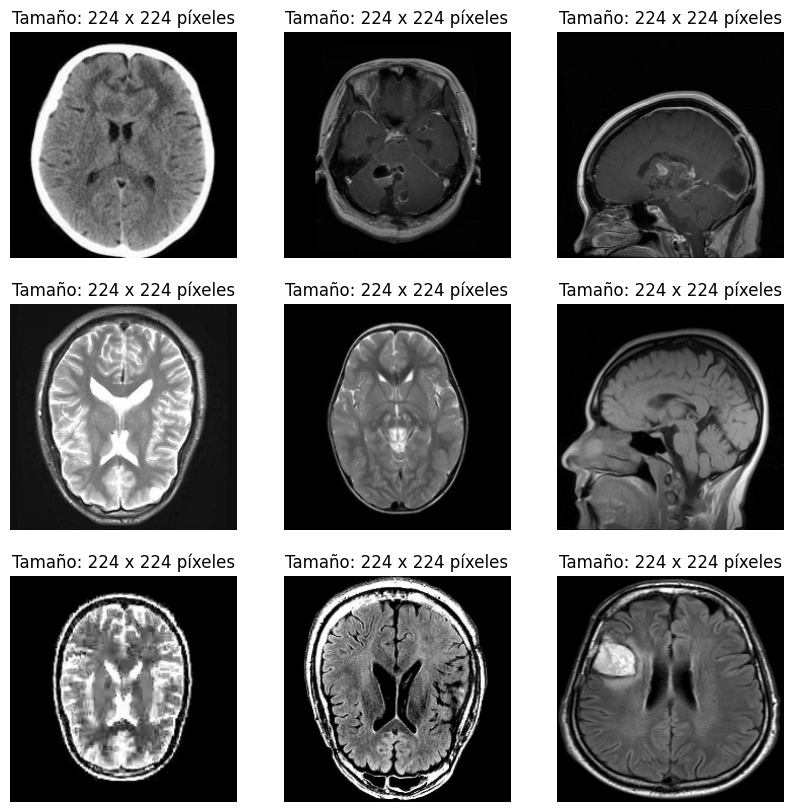

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1): # take(1) obtiene 1 batch del conjunto de datos de entrenamiento
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Tamaño: {images[i].shape[0]} x {images[i].shape[1]} píxeles")
        plt.axis("off")

plt.show()

# Aumentamos el conjunto de datos con DATA AUGMENTATION

In [ ]:
from keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])


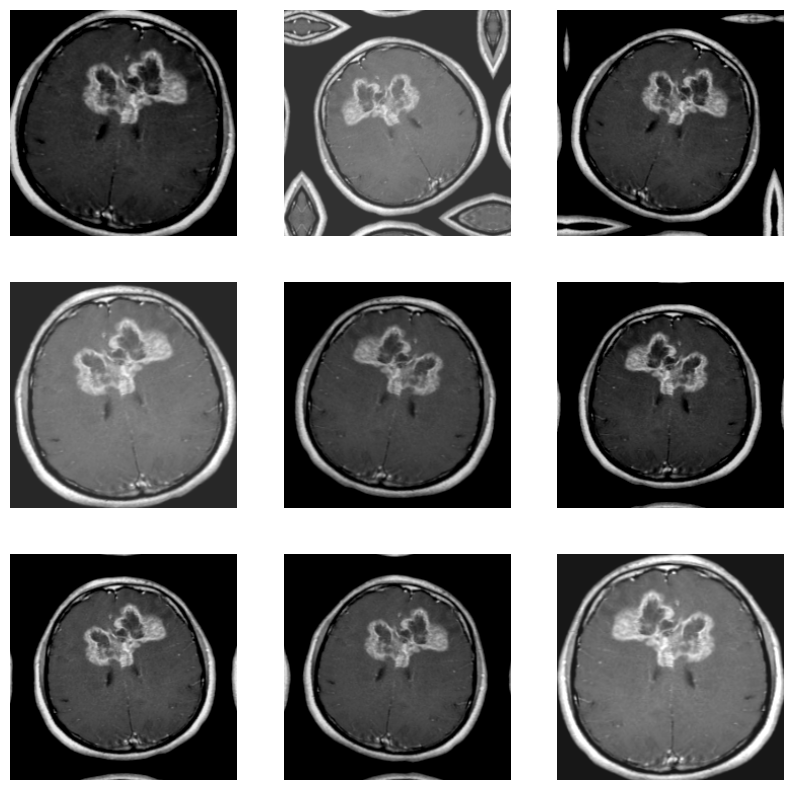

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
import tensorflow as tf

# Aplicamos "data augmentation" al conjunto de datos de entrenamiento
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Dividimos el conjunto de datos en subconjuntos de entrenamiento y validación-test

In [ ]:
# Obtenemos el suconjunto de validación
temp_val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 20% de los datos forman parte del subconjunto de validación
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4512 files belonging to 2 classes.
Using 902 files for validation.


In [ ]:
# 50% de los datos formarán parte del subconjunto de validación y 50% del de pruebas
val_size = int(0.5 * len(temp_val_ds))

In [ ]:
val_ds = temp_val_ds.take(val_size)
test_ds = temp_val_ds.skip(val_size)

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(29, 4, 4)

# Definimos la arquitectura de la Red Neuronal
Proponemos dos arquitecturas, una primera mas sencilla con la API secuencial de keras y una segunda mas compleja con la arquitectura Xception. Ponemos solo la segunda arquitectura en código, puesto es la que vamos a usar.

Primera definicion de la RNA: API Secuencial



```
from keras import layers

input_shape = (224, 224, 3) # Dimension de las imagenes

modelo_setas = keras.Sequential()

# Entrada de la red neuronal
modelo_setas.add(layers.Input(shape=input_shape))

# Escalamos las imágenes
modelo_setas.add(layers.Rescaling(1.0 / 255))

# Aplana las imágenes para la primera capa densa
modelo_setas.add(layers.Flatten())

# Layer 1
modelo_setas.add(layers.Dense(384, activation='relu'))

# Layer 2
modelo_setas.add(layers.Dense(256, activation='relu'))

# Layer 3
modelo_setas.add(layers.Dense(128, activation='relu'))

# Layer 4
modelo_setas.add(layers.Dense(9, activation='sigmoid')) # sigmoid clasificación binaria
```




Segunda arquitectura de la Red Neuronal: Xception

In [ ]:
from keras.applications import Xception
from keras import layers, models

def create_xception_model(input_shape):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Clasificación binaria
    ])
    return model

In [ ]:
brain_tumor_detector = create_xception_model((224, 224, 3))
brain_tumor_detector.build(input_shape=(None, 224, 224, 3))  # Esto asegura que el modelo sea "construido"
brain_tumor_detector.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,911,081 (83.58 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

# Configuramos la Red Neuronal

In [ ]:
# Compilamos el modelo
brain_tumor_detector.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-3), metrics=['accuracy'])

# Entrenamos la Red Neuronal


Primero balanceamos las clases para que no haya descompensaciones

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Extraer todas las etiquetas de train_ds
labels = []
for _, batch_labels in train_ds:
    labels.extend(batch_labels.numpy())

# Convertir las etiquetas a un array de NumPy
labels = np.array(labels)

# Calcular los pesos de las clases
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping y ReduceLROnPlateau para optimizar el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = brain_tumor_detector.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5341 - loss: 4.5277 - val_accuracy: 0.7090 - val_loss: 0.6987 - learning_rate: 0.0010
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6576 - loss: 1.0575 - val_accuracy: 0.7559 - val_loss: 0.5272 - learning_rate: 0.0010
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7116 - loss: 0.6591 - val_accuracy: 0.7812 - val_loss: 0.4795 - learning_rate: 0.0010
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7238 - loss: 0.5711 - val_accuracy: 0.8223 - val_loss: 0.4502 - learning_rate: 0.0010
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7398 - loss: 0.5420 - val_accuracy: 0.7441 - val_loss: 0.5174 - learning_rate: 0.0010
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7334 - loss: 0.5495 - val_accuracy: 0.7871 - val_loss: 0.4843 - learning_rate: 0.0010
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7445 - loss: 0.5240 - val_accuracy:

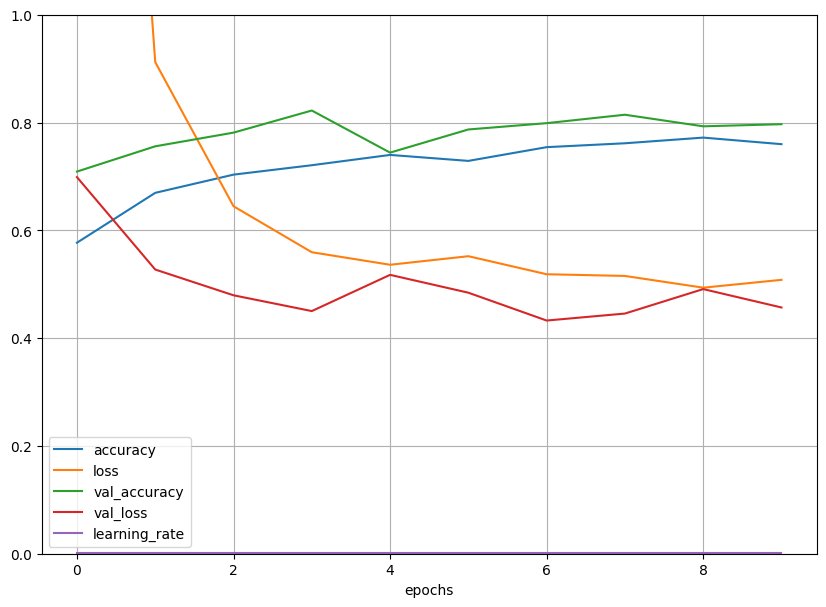

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("epochs")
plt.show()

# Guardamos el Modelo en disco y lo cargamos

In [ ]:
path_model = "/content/brain_tumor_detector.keras"

# Guardamos el modelo en disco
brain_tumor_detector.save(path_model)

# Cargamos el modelo de disco
brain_tumor_detector_disk = keras.models.load_model(path_model)

ValueError: Layer "dense_4" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_687>, <KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_688>]

# Predecimos con datos del subconjunto de test

In [ ]:
# Evaluamos el modelo con el conjunto de datos de pruebas
evaluation_result = brain_tumor_detector.evaluate(test_ds)

# Imprimir las métricas de evaluación
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8144 - loss: 0.4482
Loss: 0.44616103172302246
Accuracy: 0.8153846263885498


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


<ipython-input-35-da3ec9ac3d27>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


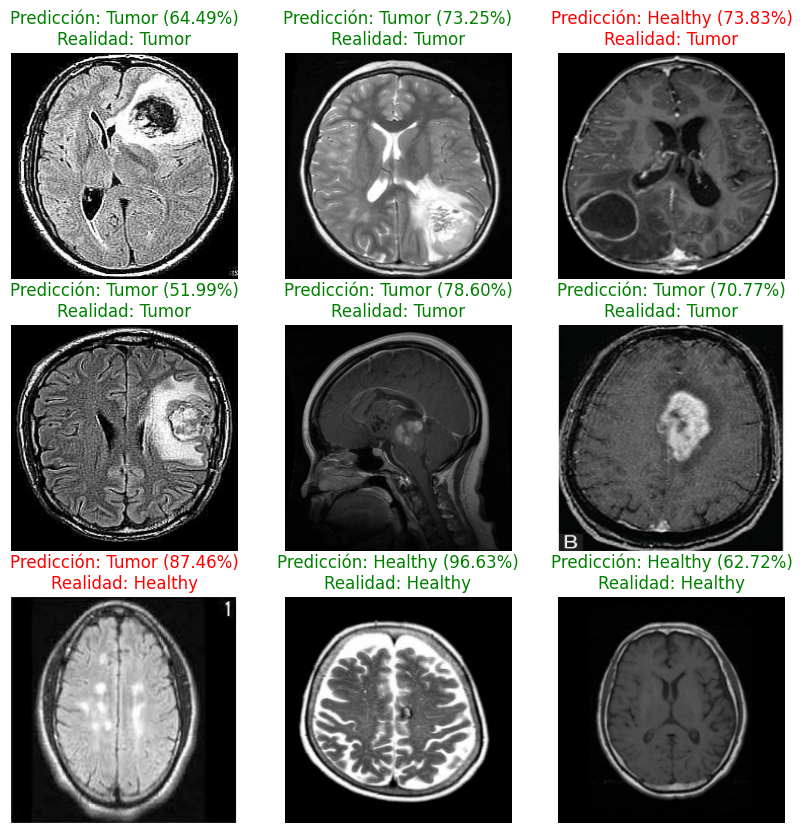

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):  # take(1) obtiene un lote del conjunto de datos (128 ejemplos)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Realizamos la predicción
        predictions = brain_tumor_detector.predict(tf.expand_dims(images[i], 0))
        score = float(predictions[0])

        # Calculamos la clase predicha (Tumor o Healthy) y la clase real
        predicted_class = "Tumor" if score < 0.5 else "Healthy"
        actual_class = "Tumor" if labels[i] == 0 else "Healthy"

        # Calculamos el porcentaje de seguridad
        predicted_percentage = 100 * (1 - score) if predicted_class == "Tumor" else 100 * score

        # Determinar el color (verde si es correcta, rojo si es incorrecta)
        text_color = "green" if predicted_class == actual_class else "red"

        # Títulos con la predicción y la clase real, con el color adecuado
        plt.title(f"Predicción: {predicted_class} ({predicted_percentage:.2f}%)\nRealidad: {actual_class}", color=text_color)
        plt.axis("off")

plt.show()
